# Single objective minimization
Consider each individual objective separately

In [1]:
using CSV, DataFrames
import PythonPlot as plt
using LaTeXStrings
using Revise, MGBO

In [2]:
const DATA_DIR = "../data/"
const IMG_DIR = "../img/"

"../img/"

In [3]:
input_df = CSV.read(joinpath(DATA_DIR, "input/nominal_scenario.csv"), DataFrame)
T = nrow(input_df)
first(input_df, 3)

3×5 DataFrame
 Row │ t      P_PV     P_WT     P_Load   Price   
     │ Int64  Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────
   1 │     1      0.0    30.09    37.76    0.324
   2 │     2      0.0    27.06    44.54    0.36
   3 │     3      0.0    26.91    48.9     0.288

In [4]:
input_data = ScenarioData(;
    P_PV = input_df.P_PV,
    P_WT = input_df.P_WT,
    P_L = input_df.P_Load,
    P_CL = input_df.P_Load .* MGBO.P_CL_ratio,
    ρ_UG_b = input_df.Price,
    ρ_UG_s = input_df.Price .* MGBO.β_UG
)
;

When using pyplot in Julia and passing a LaTeX string, we should use the `$..$` form instead of `LaTexString`.

In [5]:
plt.rc("font", size=13)
plt.rc("legend", fontsize=11)

Python: None

In [6]:
function plot_stacked_bar(res::Dict, ax)
    P_MT = res[:P_MT]
    P_BS = res[:P_BS]
    P_BS_pos = replace(x -> max(x, 0.0), P_BS)
    P_BS_neg = replace(x -> min(x, 0.0), P_BS)
    P_UG = res[:P_UG]
    P_UG_pos = replace(x -> max(x, 0.0), P_UG)
    P_UG_neg = replace(x -> min(x, 0.0), P_UG)
    P_shed = res[:P_shed]
    T = length(P_MT)
    # fig = plt.figure(figsize=(6, 3))
    # first plot positive values
    plt.sca(ax)
    plt.bar(1:T, P_MT, label=raw"$P_{\text{MT}}$", color="C0") # https://stackoverflow.com/a/47773515/14020277
    plt.bar(1:T, P_BS_pos, bottom=P_MT, label=raw"$P_{\text{BS}}$", color="C1")
    plt.bar(1:T, P_UG_pos, bottom=P_MT .+ P_BS_pos, label=raw"$P_{\text{UG}}$", color="C2")
    plt.bar(1:T, P_shed, bottom=P_MT .+ P_BS_pos .+ P_UG_pos, label=raw"$P_{\text{shed}}$", color="C3")
    # now plot negative values
    plt.bar(1:T, P_BS_neg, color="C1")
    plt.bar(1:T, P_UG_neg, bottom=P_BS_neg, color="C2")
    plt.legend()
    # plt.xlabel("Time (h)")
    plt.ylabel("Power (kW)")
    plt.gca().set_axisbelow(true) # https://stackoverflow.com/a/68344604/14020277
    plt.grid(true)
end

plot_stacked_bar (generic function with 1 method)

## first objective

In [7]:
model1 = single_objective_minimize(input_data, 1; log_level=0)
;

In [8]:
model1[:result][:P_MT]'

1×24 adjoint(::Vector{Float64}) with eltype Float64:
 15.0  15.0  10.0  15.0  18.37  20.0  …  30.0  35.0  35.0  30.0  15.0  15.0

## second objective

In [9]:
model2 = single_objective_minimize(input_data, 2; log_level=0);

## visualize results of two cases

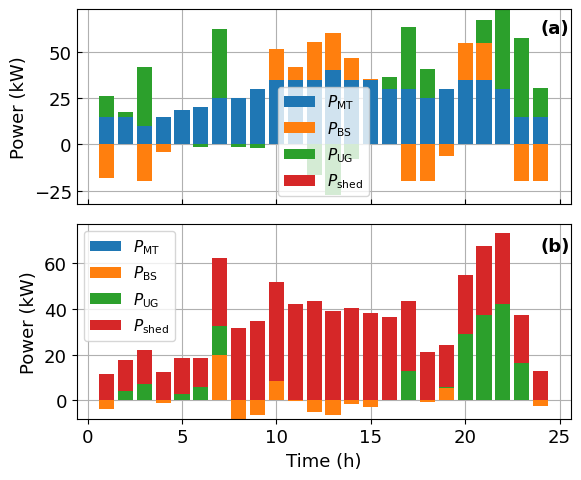

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), layout="tight")
# note that axs[0] is set the current axis by `sca` in the function below
plot_stacked_bar(model1[:result], axs[0])
plt.tick_params(labelbottom=false, direction="in")  # remove the tick labels but keep ticks and the grid line
plt.text(24, 60, "(a)", fontweight="bold")
plot_stacked_bar(model2[:result], axs[1])
plt.xlabel("Time (h)")
plt.text(24, 65, "(b)", fontweight="bold")
fig

In [24]:
# plt.savefig does not work for some reason
fig.savefig(joinpath(IMG_DIR, "so.pdf"), bbox_inches="tight")

Python: None

## Objectives of the two cases

In [12]:
model1[:result][:f1], model1[:result][:f2]

(297.731739563158, 822.9996625263155)

In [13]:
model2[:result][:f1], model2[:result][:f2]

(752.016058984, 136.5431864)